<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Hands on Lab: Complete the Machine Learning Prediction lab


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method that performs best using test data


## Import Libraries and Define Auxiliary Functions


In [8]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [9]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,  recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

This function is to plot the confusion matrix.


In [3]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [4]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [6]:
data.shape

(90, 18)

In [7]:
data['LaunchSite'].unique()

array(['CCAFS SLC 40', 'VAFB SLC 4E', 'KSC LC 39A'], dtype=object)

In [8]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [9]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [10]:
data.to_csv('SpaceX_Machine Learning Prediction_Part_5(1).csv', index=False)
X.to_csv('SpaceX_Machine Learning Prediction_Part_5(2).csv', index=False)

## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [10]:
Y = data.Class.to_numpy()  # or .values
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [11]:
X.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,45.500000,6104.959412,1.788889,3.500000,1.655556,0.011111,0.011111,0.300000,0.011111,0.233333,...,0.033333,0.044444,0.033333,0.011111,0.222222,0.777778,0.588889,0.411111,0.211111,0.788889
std,26.124701,4694.671720,1.213172,1.595288,1.710254,0.105409,0.105409,0.460825,0.105409,0.425322,...,0.180511,0.207235,0.180511,0.105409,0.418069,0.418069,0.494792,0.494792,0.410383,0.410383
min,1.000000,350.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.250000,2510.750000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,45.500000,4701.500000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,67.750000,8912.750000,2.000000,5.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,90.000000,15600.000000,6.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# students get this 
transform = preprocessing.StandardScaler()
scaled_X = transform.fit_transform(X)
scaled_X

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.67441914e+00, -1.19523159e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.63592675e+00, -1.16267307e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       ...,
       [ 1.63592675e+00,  1.99100483e+00,  3.49060516e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.67441914e+00,  1.99100483e+00,  1.00389436e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.71291154e+00, -5.19213966e-01, -6.53912840e-01, ...,
        -8.35531692e-01, -5.17306132e-01,  5.17306132e-01]])

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


In [13]:
pd.DataFrame(scaled_X).describe()

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
count,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,...,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01
mean,1.480297e-17,-1.418618e-16,-7.278129e-17,-1.973730e-17,5.921189e-17,-4.810966e-17,-2.868076e-17,-7.401487e-18,-4.810966e-17,4.687608e-17,...,-1.973730e-17,3.515706e-17,-2.220446e-17,-1.973730e-17,7.648203e-17,-7.648203e-17,3.700743e-18,-3.700743e-18,-2.220446e-17,2.220446e-17
std,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,...,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00
min,-1.712912e+00,-1.232717e+00,-6.539128e-01,-1.575895e+00,-9.734405e-01,-1.059998e-01,-1.059998e-01,-6.546537e-01,-1.059998e-01,-5.516773e-01,...,-1.856953e-01,-2.156655e-01,-1.856953e-01,-1.059998e-01,-5.345225e-01,-1.870829e+00,-1.196843e+00,-8.355317e-01,-5.173061e-01,-1.933091e+00
25%,-8.564558e-01,-7.698824e-01,-6.539128e-01,-9.455367e-01,-9.734405e-01,-1.059998e-01,-1.059998e-01,-6.546537e-01,-1.059998e-01,-5.516773e-01,...,-1.856953e-01,-2.156655e-01,-1.856953e-01,-1.059998e-01,-5.345225e-01,5.345225e-01,-1.196843e+00,-8.355317e-01,-5.173061e-01,5.173061e-01
50%,0.000000e+00,-3.006221e-01,-6.539128e-01,3.151789e-01,-3.854563e-01,-1.059998e-01,-1.059998e-01,-6.546537e-01,-1.059998e-01,-5.516773e-01,...,-1.856953e-01,-2.156655e-01,-1.856953e-01,-1.059998e-01,-5.345225e-01,5.345225e-01,8.355317e-01,-8.355317e-01,-5.173061e-01,5.173061e-01
75%,8.564558e-01,6.014309e-01,1.749908e-01,9.455367e-01,7.905120e-01,-1.059998e-01,-1.059998e-01,1.527525e+00,-1.059998e-01,-5.516773e-01,...,-1.856953e-01,-2.156655e-01,-1.856953e-01,-1.059998e-01,-5.345225e-01,5.345225e-01,8.355317e-01,1.196843e+00,-5.173061e-01,5.173061e-01
max,1.712912e+00,2.033845e+00,3.490605e+00,9.455367e-01,1.966480e+00,9.433981e+00,9.433981e+00,1.527525e+00,9.433981e+00,1.812654e+00,...,5.385165e+00,4.636809e+00,5.385165e+00,9.433981e+00,1.870829e+00,5.345225e-01,8.355317e-01,1.196843e+00,1.933091e+00,5.173061e-01


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [14]:
X_train, X_test, Y_train, Y_test  = train_test_split(scaled_X, Y, test_size=0.2, random_state = 2)

we can see we only have 18 test samples.


In [15]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [16]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [17]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(estimator= lr, param_grid= parameters, cv=10, scoring='accuracy', verbose=0)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy')

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [18]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [19]:
accuracy_lr = logreg_cv.score(X_test, Y_test)
print(f"Test accuracy: {accuracy_lr:.4f}")

Test accuracy: 0.8333


In [20]:
# recall_score_LR = recall_score(y_test,y_pred, average='weighted')
# accuracy_score_LR = accuracy_score(y_test,y_pred)

Lets look at the confusion matrix:


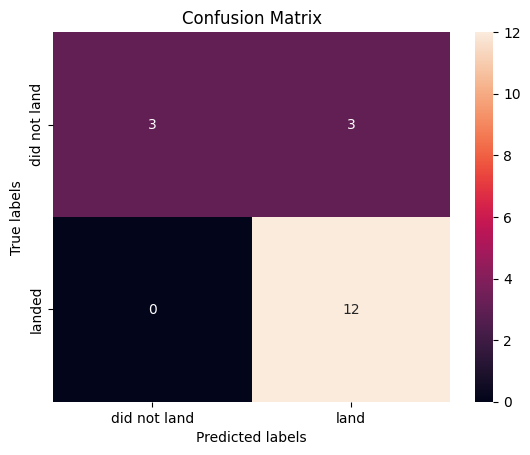

In [21]:
yhat_lr =logreg_cv.predict(X_test)
conf_matrix_lr = confusion_matrix(Y_test,yhat_lr)
plot_confusion_matrix(Y_test,yhat_lr)

In [22]:
print(classification_report(Y_test,yhat_lr))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



In [23]:
yhat_lr_proba_ = logreg_cv.predict_proba(X_test)[:, 1]
auc_score_lr = roc_auc_score(Y_test, yhat_lr_proba_)
auc_score_lr

0.888888888888889

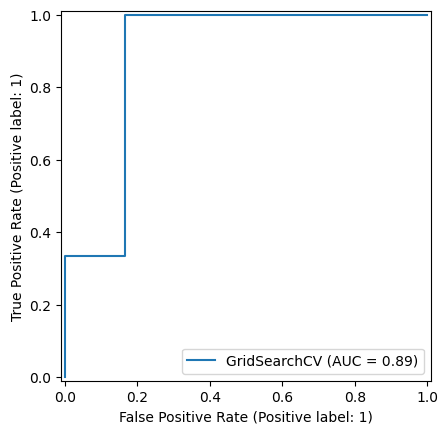

In [24]:
lr_disp = RocCurveDisplay.from_estimator(logreg_cv, X_test, Y_test)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.

Overview:

True Postive - 12 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [25]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC(probability=True)

In [26]:
svm_cv = GridSearchCV(estimator= svm, param_grid= parameters, cv=10, scoring='accuracy', verbose=0)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(probability=True),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy')

In [27]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [28]:
accuracy_svm = svm_cv.score(X_test, Y_test)
print(f"Test accuracy: {accuracy_svm:.4f}")

Test accuracy: 0.8333


We can plot the confusion matrix


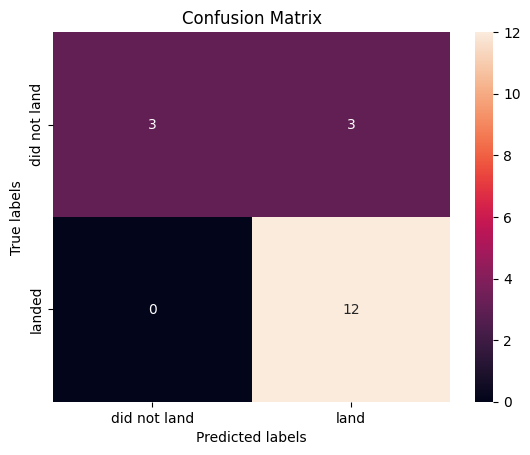

In [29]:
yhat_svm =svm_cv.predict(X_test)
conf_matrix_svm = confusion_matrix(Y_test,yhat_svm)
plot_confusion_matrix(Y_test,yhat_svm)

In [30]:
print(classification_report(Y_test,yhat_svm))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



In [31]:
yhat_svm_proba_ = svm_cv.predict_proba(X_test)[:, 1]
auc_score_svm = roc_auc_score(Y_test, yhat_svm_proba_)
auc_score_svm

0.9583333333333334

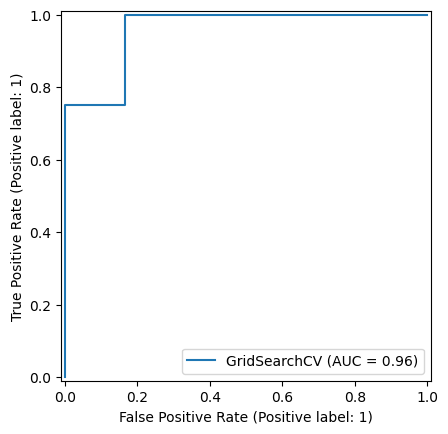

In [32]:
svm_disp = RocCurveDisplay.from_estimator(svm_cv, X_test, Y_test)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [34]:

parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['log2', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier(random_state = 2)

In [35]:
tree_cv = GridSearchCV(estimator= tree, param_grid= parameters, cv=10, scoring='accuracy', verbose=0 )
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=2),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [36]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8767857142857143


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [37]:
accuracy_tree = tree_cv.score(X_test, Y_test)
print(f"Test accuracy: {accuracy_tree:.4f}")

Test accuracy: 0.8333


We can plot the confusion matrix


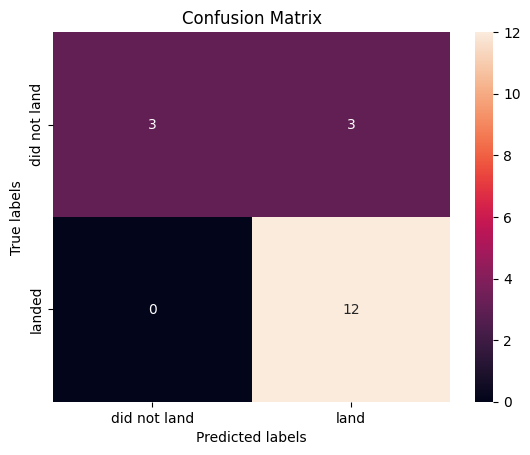

In [38]:
yhat_tree = tree_cv.predict(X_test)
conf_matrix_tree = confusion_matrix(Y_test,yhat_tree)
plot_confusion_matrix(Y_test,yhat_tree)

In [39]:
print(classification_report(Y_test,yhat_tree))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



In [40]:
yhat_tree_proba_ = tree_cv.predict_proba(X_test)[:, 1]
auc_score_tree = roc_auc_score(Y_test, yhat_tree_proba_)
auc_score_tree

0.7361111111111112

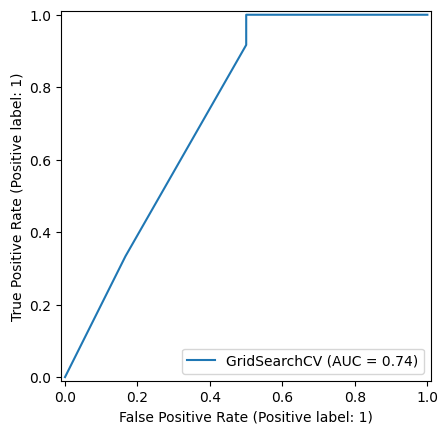

In [41]:
tree_disp = RocCurveDisplay.from_estimator(tree_cv, X_test, Y_test)

In [42]:
tree_cv.predict_proba(X_test)[:,1]

array([0.8       , 1.        , 0.8       , 1.        , 0.8       ,
       1.        , 0.8       , 0.        , 1.        , 0.14285714,
       0.14285714, 0.8       , 0.8       , 1.        , 0.8       ,
       0.66666667, 0.8       , 0.8       ])

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [43]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [44]:

knn_cv = GridSearchCV(estimator= KNN, param_grid= parameters, cv=10, scoring='accuracy', verbose=0)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             scoring='accuracy')

In [45]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [46]:
accuracy_knn = knn_cv.score(X_test, Y_test)
print(f"Test accuracy: {accuracy_knn:.4f}")

Test accuracy: 0.8333


We can plot the confusion matrix


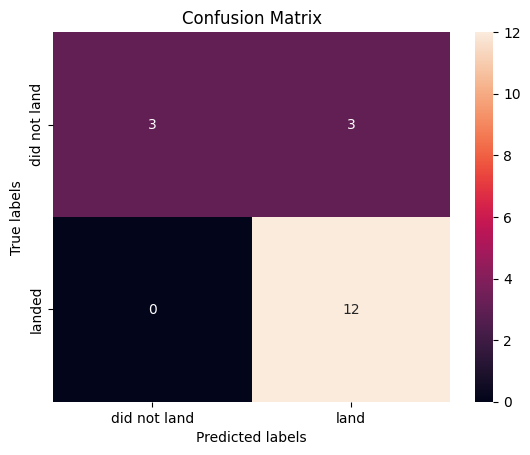

In [47]:
yhat_knn = knn_cv.predict(X_test)
conf_matrix_knn = confusion_matrix(Y_test,yhat_knn)
plot_confusion_matrix(Y_test,yhat_knn)

In [48]:
print(classification_report(Y_test,yhat_knn))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



In [49]:
yhat_knn_proba_ = knn_cv.predict_proba(X_test)[:, 1]
auc_score_knn = roc_auc_score(Y_test, yhat_knn_proba_)
auc_score_knn

0.8958333333333334

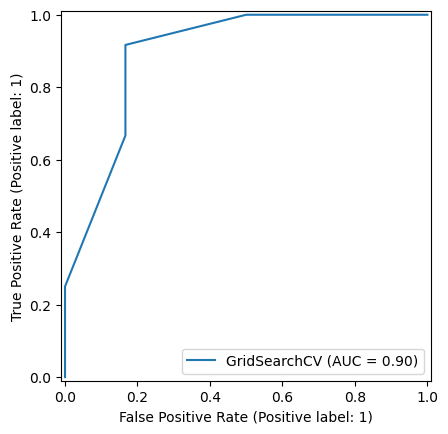

In [50]:
knn_disp = RocCurveDisplay.from_estimator(knn_cv, X_test, Y_test)

## TASK  12


Find the method performs best:


In [51]:

print( logreg_cv.best_score_)
print( svm_cv.best_score_)
print( tree_cv.best_score_)
print( knn_cv.best_score_)      # Cross-Calidation Accuracy Score

0.8464285714285713
0.8482142857142856
0.8767857142857143
0.8482142857142858


This gives the mean **Cross-Calidation Accuracy Score** from your GridSearchCV (or cross_val_score) across all training folds during tuning.
Interpretation:

“How well did the model perform during cross-validation on the training set?”

Used for model selection, especially during hyperparameter tuning.

Based on internal training folds, not the holdout test set.

In [52]:
print(accuracy_lr)      
print(accuracy_svm)         # Accuracy
print(accuracy_tree)
print(accuracy_knn)                  # eg knn_cv.score(X_test, Y_test)

0.8333333333333334
0.8333333333333334
0.8333333333333334
0.8333333333333334


This evaluates the best model found by GridSearchCV on the unseen test data using .score(), which for classifiers = **accuracy by default.**

Interpretation:

“How well does the tuned model generalize to the test set?”

This is your true evaluation of performance on new data.
**More realistic measure of generalization than best_score_.**

In [53]:
print (accuracy_score(Y_test, yhat_lr))
print (accuracy_score(Y_test, yhat_svm))
print (accuracy_score(Y_test, yhat_tree))
print (accuracy_score(Y_test, yhat_knn))

0.8333333333333334
0.8333333333333334
0.8333333333333334
0.8333333333333334


accuracy_score(y_test, y_pred),  which requires you to import "from sklearn.metrics import accuracy_score" (also classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score etc.) computes accuracy manually from predicted(**yhat**) and true labels(**Y_test**).

Interpretation:

“What proportion of predictions were correct?”

**Same as .score()** but gives you more control you can swap in other metrics.

You need to manually call .predict() beforehand. **eg yhat_knn = knn_cv.predict(X_test)**

In [54]:
recall_lr = recall_score(Y_test,yhat_lr)   # True Positive
recall_svm = recall_score(Y_test,yhat_svm)
recall_tree = recall_score(Y_test,yhat_tree)
recall_knn = recall_score(Y_test,yhat_knn)
print(recall_lr,"\n", recall_svm,"\n", recall_tree,"\n", recall_knn)

1.0 
 1.0 
 1.0 
 1.0


In [55]:
recall_FalseP_lr = recall_score(Y_test, yhat_lr, average = None)[0]   # False Positve
recall_FalseP_svm = recall_score(Y_test, yhat_svm, average = None)[0]
recall_FalseP_tree = recall_score(Y_test, yhat_tree, average = None)[0]
recall_FalseP_knn = recall_score(Y_test, yhat_knn, average = None)[0]


In [56]:
recall_FalseP_knn

0.5

In [57]:
conf_matrix_tree

array([[ 3,  3],
       [ 0, 12]], dtype=int64)

In [58]:
correctP_lr = conf_matrix_lr[0,0]+conf_matrix_lr[1,1]            #No of Correct Predictions	
correctP_svm = conf_matrix_svm[0,0]+conf_matrix_svm[1,1]
correctP_tree = conf_matrix_tree[0,0]+conf_matrix_tree[1,1]
correctP_knn = conf_matrix_knn[0,0]+conf_matrix_knn[1,1]

In [59]:
best_model_df = pd.DataFrame(index = ['Accuracy %', 'Cross-Validation Accuracy Score', 'No of Correct Predictions' , 'TruePositive %', 'FalsePositive %', 'ROC_AUC'], columns = ['Logistic Regression', 'SVM', 'Decision Tress', 'KNN'])
best_model_df

,Logistic Regression,SVM,Decision Tress,KNN
Accuracy %,NaN,NaN,NaN,NaN
Cross-Validation Accuracy Score,NaN,NaN,NaN,NaN
No of Correct Predictions,NaN,NaN,NaN,NaN
TruePositive %,NaN,NaN,NaN,NaN
FalsePositive %,NaN,NaN,NaN,NaN
ROC_AUC,NaN,NaN,NaN,NaN


In [60]:
accuracy  = np.array([accuracy_lr, accuracy_svm,  accuracy_tree, accuracy_knn])
correctpredictions  = np.array([correctP_lr, correctP_svm, correctP_tree, correctP_knn])
Truepositve_recall =  np.array([recall_lr, recall_svm, recall_tree, recall_knn])
FalsePositive_recall1 = np.array([recall_FalseP_lr, recall_FalseP_svm, recall_FalseP_tree, recall_FalseP_knn])
CV_acc_Score = np.array([logreg_cv.best_score_, svm_cv.best_score_, tree_cv.best_score_, knn_cv.best_score_])
ROC_AUC = np.array([auc_score_lr, auc_score_svm, auc_score_tree, auc_score_knn])


In [61]:
best_model_df.loc['Accuracy %'] = np.round(accuracy*100, 2)
best_model_df.loc['Cross-Validation Accuracy Score'] = np.round(CV_acc_Score*100,2)
best_model_df.loc['No of Correct Predictions'] = correctpredictions
best_model_df.loc['TruePositive %'] = np.round(Truepositve_recall*100,2)
best_model_df.loc['FalsePositive %'] = np.round(FalsePositive_recall1*100,2)
best_model_df.loc['ROC_AUC'] = np.round(ROC_AUC*100, 2)

In [62]:
best_model_df

,Logistic Regression,SVM,Decision Tress,KNN
Accuracy %,83.33,83.33,83.33,83.33
Cross-Validation Accuracy Score,84.64,84.82,87.68,84.82
No of Correct Predictions,15,15,15,15
TruePositive %,100.0,100.0,100.0,100.0
FalsePositive %,50.0,50.0,50.0,50.0
ROC_AUC,88.89,95.83,73.61,89.58


In [63]:
acc_bestmodel = best_model_df.loc['Accuracy %']
acc_bestmodel = pd.DataFrame(acc_bestmodel).reset_index()
acc_bestmodel = acc_bestmodel.rename(columns={'index': 'Model'})

In [64]:
acc_bestmodel

,Model,Accuracy %
0,Logistic Regression,83.33
1,SVM,83.33
2,Decision Tress,83.33
3,KNN,83.33


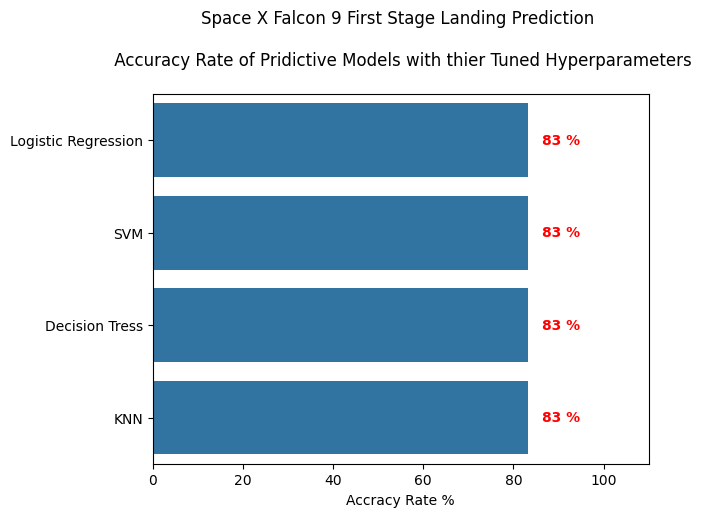

In [65]:
ax = sns.barplot(acc_bestmodel, y= 'Model', x='Accuracy %' )

# Add labels on top of each bar
for i, value in enumerate(acc_bestmodel['Accuracy %']):
        ax.text(value + 3, i, f"{value:.0f} %", va='center', fontweight='bold', color='red')


plt.title("Space X Falcon 9 First Stage Landing Prediction \n \n Accuracy Rate of Pridictive Models with thier Tuned Hyperparameters\n")
plt.xlabel('Accracy Rate %')
plt.xlim(0,110)
plt.ylabel('')
plt.show()

In [66]:
svm_cv.predict_proba(X_test)#[:, 1]

array([[0.17604288, 0.82395712],
       [0.11026907, 0.88973093],
       [0.12328867, 0.87671133],
       [0.1497494 , 0.8502506 ],
       [0.07521231, 0.92478769],
       [0.1016201 , 0.8983799 ],
       [0.11153252, 0.88846748],
       [0.87391227, 0.12608773],
       [0.15207807, 0.84792193],
       [0.80952063, 0.19047937],
       [0.81038514, 0.18961486],
       [0.27300021, 0.72699979],
       [0.18998944, 0.81001056],
       [0.12878096, 0.87121904],
       [0.08469892, 0.91530108],
       [0.13762839, 0.86237161],
       [0.27259334, 0.72740666],
       [0.20587756, 0.79412244]])

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/)


<!--## Change Log--!>


<!--| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|--!>


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
